---

This notebook contains code to re-create Figures 2 & 3 from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, D. Tabb, Miguel Carcamo & Joe Hanson

---

In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys

In [2]:
pl.rcParams['figure.figsize'] = [20, 5]
pl.rcParams['figure.dpi'] = 300

---
### Data Creation

Set the parameters for the two model scenarios from Brentjens & deBruyn (2005):

In [3]:
phi_fg = 10.
phi_gal = 50.

scen1 = True
scen2 = False

Specify the sampling in frequency and lambda^2:

In [4]:
const_c = 3e8

nu_min = 0.58e9
nu_max = 2.50e9

l2_min = (const_c/nu_max)**2
l2_max = (const_c/nu_min)**2

# make data regularly spaced in frequency:
nu = np.linspace(nu_min, nu_max, 512)
l2 = (const_c/nu)**2

# make data regularly spaced in lambda^2:
t1 = np.linspace(l2_min, l2_max, 512)

Define a function for BdB05 Scenario 1:

In [5]:
def make_scenario1(phi_gal, l2):
    
    p0 = 1.0
    alpha = 0.7
    nu0 = 1.4e9
    nu = 3e8/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*phi_gal*l2)
    mu_u = p0*k*np.sin(2.*phi_gal*l2)
    
    p = np.mean(np.sqrt(mu_q**2+mu_u**2))
    
    return mu_q, mu_u

Define a function for BdB05 Scenario 2:

In [6]:
def make_scenario2(phi_fg, phi_gal, l2):
    
    p_fg = 1.0
    p_gal = 0.25
    mu_q = p_fg*np.sin(2*phi_fg*l2)/(2.*phi_fg*l2) + p_gal*np.cos(2.*phi_gal*l2)
    mu_u = p_gal*np.sin(2.*phi_gal*l2)
    
    return mu_q, mu_u

Create the QU data for the differently sampled datasets:

In [7]:
if scen1:
    mu_q, mu_u = make_scenario1(phi_gal, t1)
    stokesQ, stokesU = make_scenario1(phi_gal, l2)
elif scen2:
    mu_q, mu_u = make_scenario2(phi_fg, phi_gal, t1)
    stokesQ, stokesU = make_scenario2(phi_fg, phi_gal, l2)

Plot the simulated data:

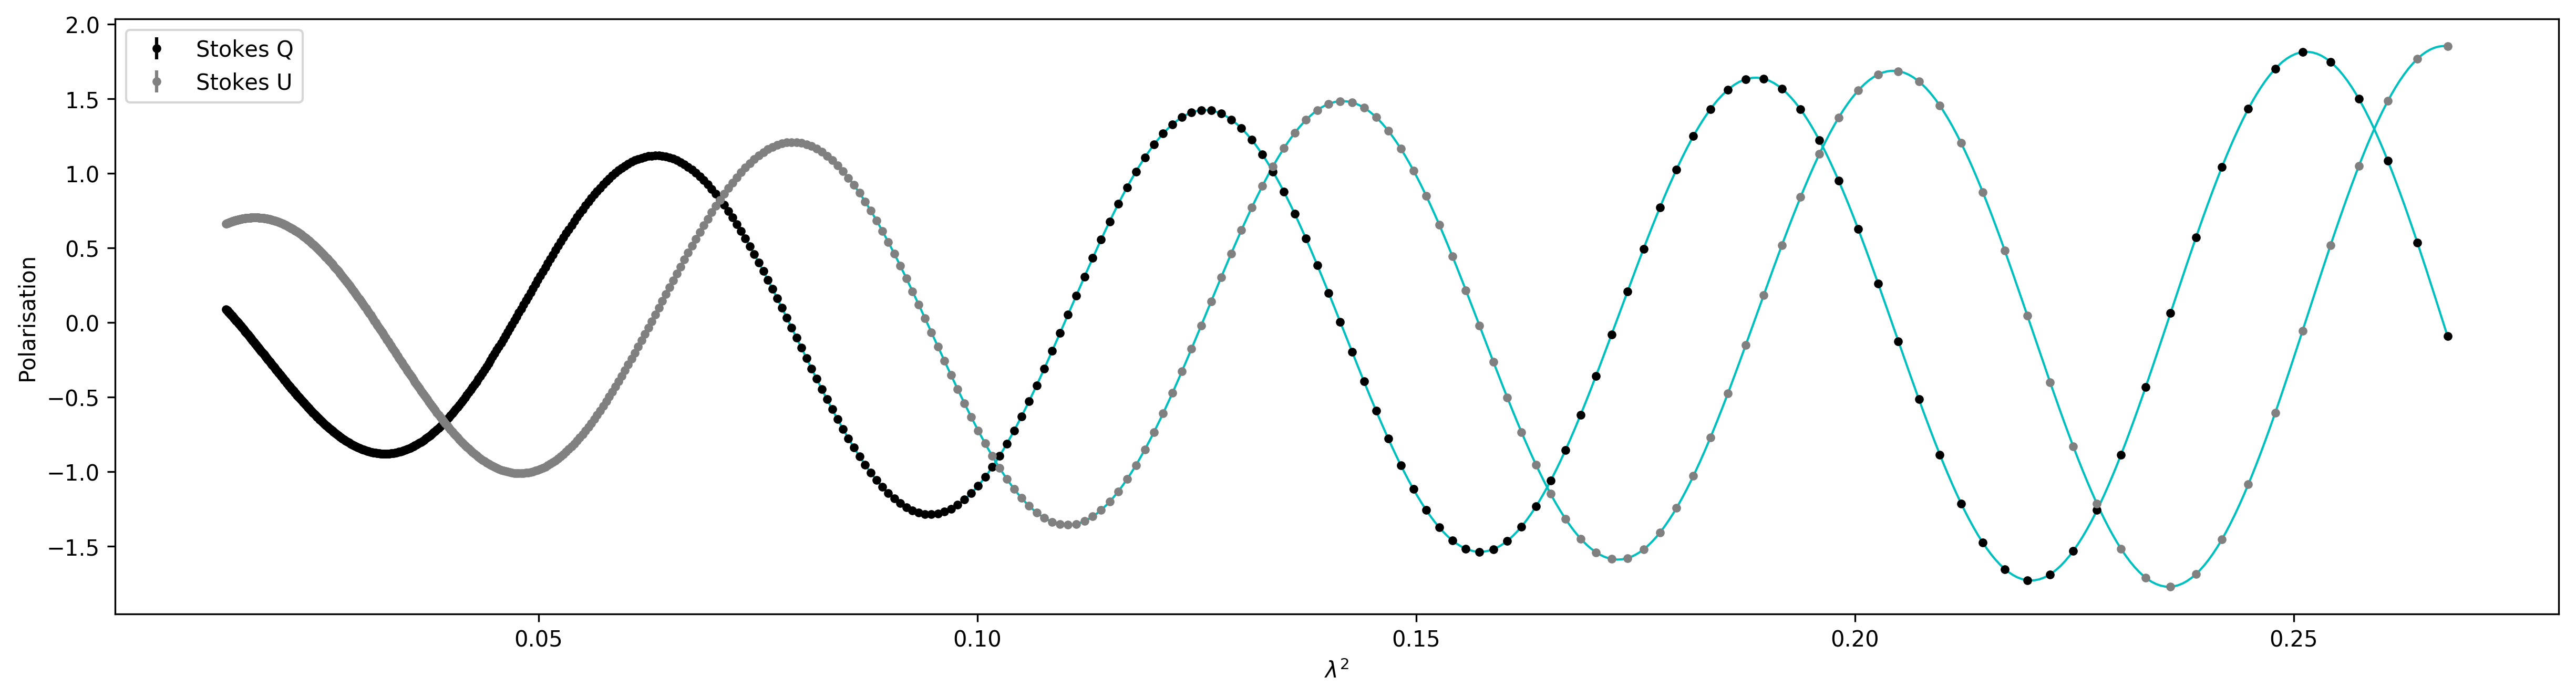

In [8]:
ax2 = pl.subplot(111)

ax2.plot(t1, mu_q, linestyle='-', color = 'c', lw=1.0)
ax2.plot(t1, mu_u, linestyle='-', color = 'c', lw=1.0)

ax2.errorbar(l2[::-1],stokesQ[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(l2[::-1],stokesU[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")
ax2.set_xlabel(r"$\lambda^2$")

ax2.legend()
pl.show()

---

### RM Synthesis

In [9]:
phi = np.linspace(-500,500,10000)

In [10]:
def calc_k(w):
    
    k = np.sum(w)
    
    return k

In [11]:
def calc_l0(w,l2):
    
    k = calc_k(w)
    l0 = (1./k)*np.sum(w*l2)
    
    return l0

In [12]:
def calc_f(phi,l2,q,u,w):
    
    p = q+1j*u
    k = calc_k(w)
    l0 = calc_l0(w,l2)
    f = (1./k)*np.sum(w*p*np.exp(-2*1j*(l2-l0)*phi))
    
    return f

In [13]:
def calc_r(phi,l2,w):
    
    k = calc_k(w)
    l0 = calc_l0(w,l2)
    r = (1./k)*np.sum(w*np.exp(-2*1j*(l2-l0)*phi))
    
    return r

Run RM synthesis on the data regularly sampled in lambda^2:

In [14]:
fspec = []
rmtf = []
w = np.ones(len(mu_q))
    
for i in range(0,len(phi)):
    fspec.append(calc_f(phi[i],t1,mu_q,mu_u,w))
    rmtf.append(calc_r(phi[i],t1,w))
    
fspec = np.array(fspec)
rmtf = np.array(rmtf)

Make Fig 2 (bottom):

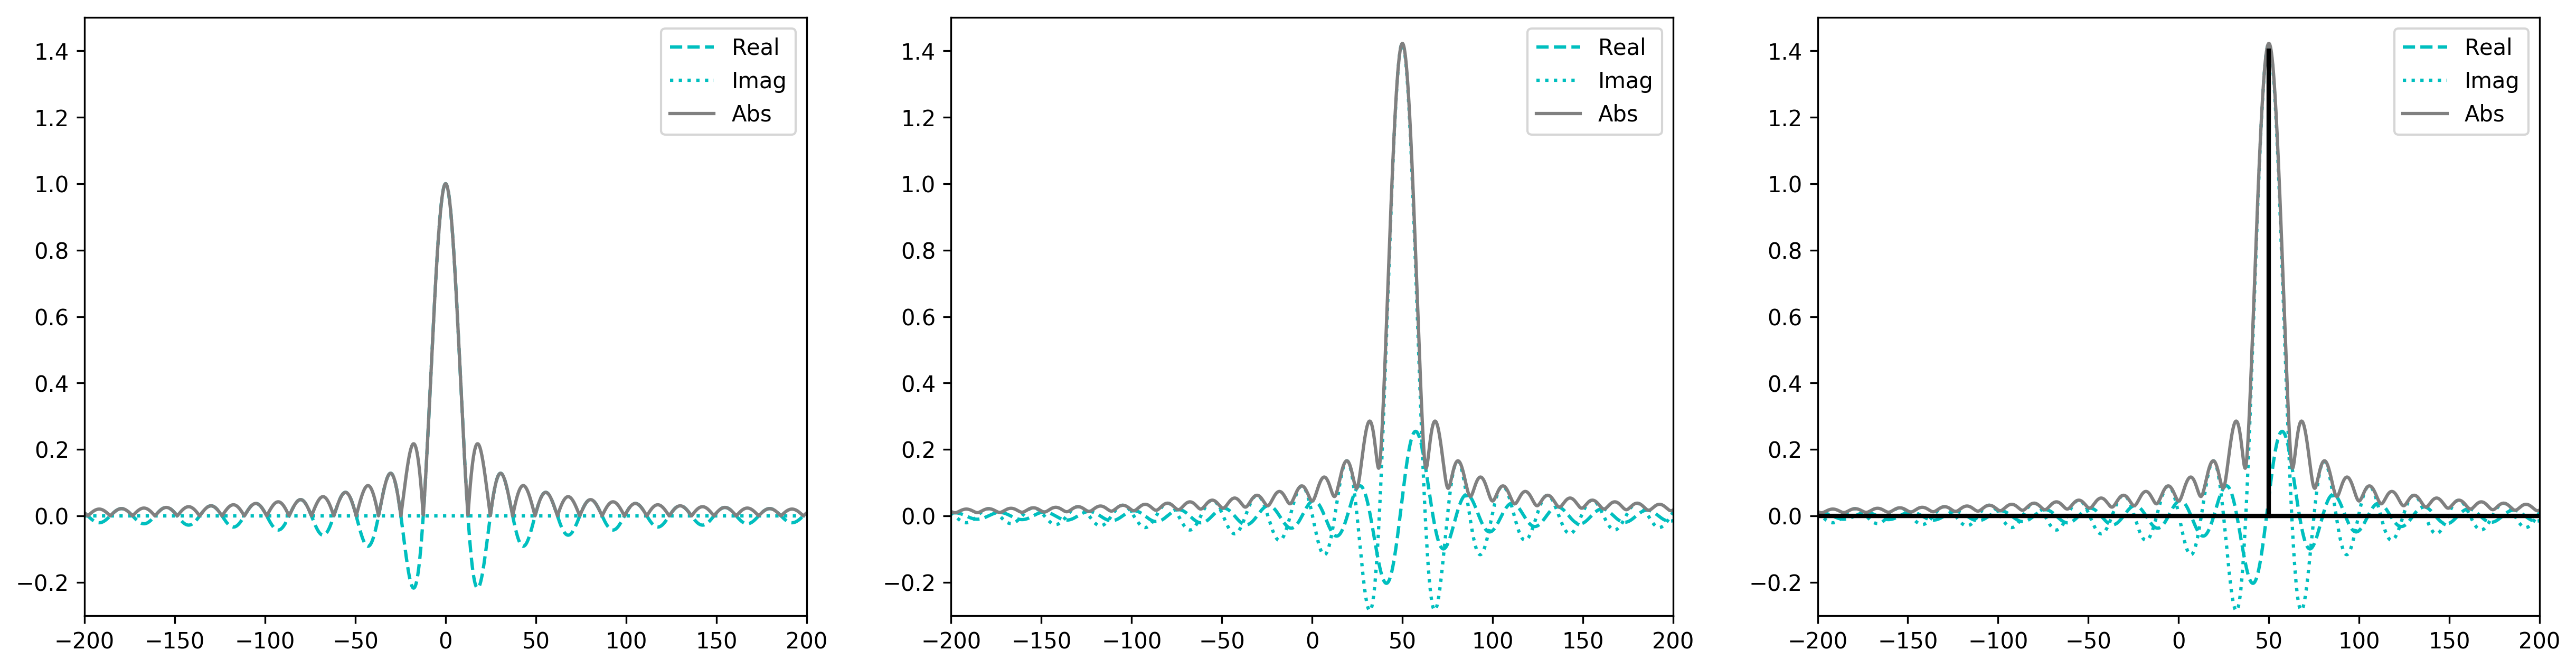

In [15]:
pl.subplot(131)
pl.plot(phi,np.real(rmtf),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(rmtf),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(rmtf),ls='-',c='grey',label="Abs")
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)
pl.legend()

pl.subplot(132)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.subplot(133)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")

pl.plot(phi,np.zeros(len(phi)),ls='-',lw=2.,c='black')
if scen1:
    pl.plot([50.,50.],[0.,1.4],ls='-',lw=2.,c='black')
elif scen2:
    pl.plot([50.,50.],[0.,0.25],ls='-',lw=2.,c='black')
    pl.plot([10.,10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,-10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,10.],[1.0,1.0],ls='-',lw=2.,c='black',label="Model")
    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.show()

Run RM synthesis on data regularly sampled in frequency:

In [16]:
fspec = []
rmtf = []
w = np.ones(len(stokesQ))
    
for i in range(0,len(phi)):
    fspec.append(calc_f(phi[i],l2[::-1],stokesQ[::-1],stokesU[::-1],w))
    rmtf.append(calc_r(phi[i],l2[::-1],w))
    
fspec = np.array(fspec)
rmtf = np.array(rmtf)

Make Fig 2 (top):

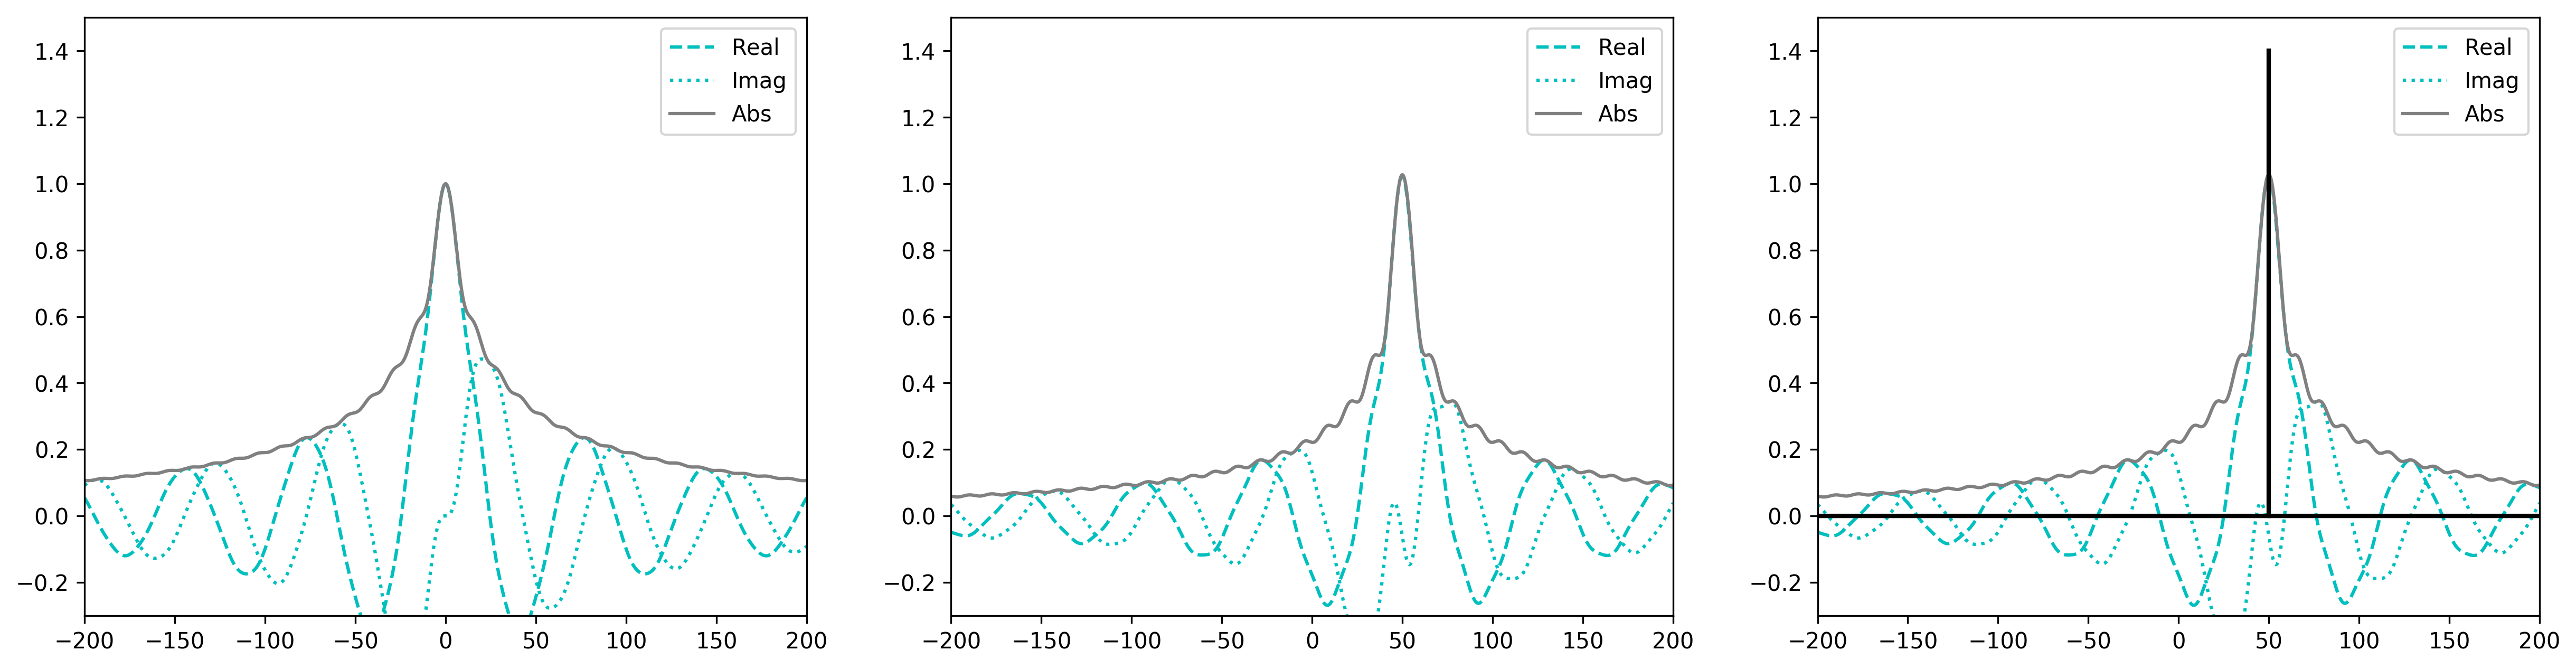

In [17]:
pl.subplot(131)
pl.plot(phi,np.real(rmtf),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(rmtf),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(rmtf),ls='-',c='grey',label="Abs")
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)
pl.legend()

pl.subplot(132)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.subplot(133)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")

pl.plot(phi,np.zeros(len(phi)),ls='-',lw=2.,c='black')
if scen1:
    pl.plot([50.,50.],[0.,1.4],ls='-',lw=2.,c='black')
elif scen2:
    pl.plot([50.,50.],[0.,0.25],ls='-',lw=2.,c='black')
    pl.plot([10.,10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,-10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,10.],[1.0,1.0],ls='-',lw=2.,c='black',label="Model")
    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.show()

---
#### END
